## Gather

In [ ]:
import pandas as pd
import numpy as np
import re
import requests
import tweepy
import timeit
import json
import matplotlib.pyplot as plt
%matplotlib inline

#### Keys

In [ ]:
consumer_key = 'NOT SHOWN' 
consumer_secret = 'NOT SHOWN'

access_token = 'NOT SHOWN' 
access_token_secret = 'NOT SHOWN' 

In [ ]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
req = requests.get(url, auth=('user','pass'));
open('image_predictions.tsv', 'wb').write(req.content);

In [ ]:
img_pred = pd.read_csv('image_predictions.tsv', sep='\t');

In [ ]:
tweet_archive = pd.read_csv('twitter-archive-enhanced.csv');

In [ ]:
tweet_archive

In [ ]:
#Query Twitter API for Tweet JSON data
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

#Call API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


#api.get_status(tweet_id, tweet_mode='extended')

In [ ]:
num_tweets = 200
start = timeit.timeit()
tweets = []
deleted_tweets = []
#for tweet in tweepy.Cursor(api.user_timeline, screen_name='dog_rates').items(num_tweets):
#        tweets.append(tweet)
for tweet_id in tweet_archive.tweet_id:
    try:
        tweet = api.get_status(id=tweet_id)
        tweets.append(tweet)
    except tweepy.TweepError:
        deleted_tweets.append(tweet_id)
end = timeit.timeit()
print("Gathering Tweets took a total of ", end - start)

In [ ]:
with open("tweet_json.txt","w") as file:
    for tweet in tweets:
        json.dump(tweet._json, file, ensure_ascii=False)
        file.write('\n')
#tmp = [[tweet.id_str, tweet.retweet_count, tweet.favorite_count, tweet.text.encode('utf-8')] for tweet in tweets]
#df = pd.read_csv(tweets_for_csv)


In [ ]:
tweet_data = pd.DataFrame({}, columns =['tweet_id', 'description','retweet_count', 'favorite_count'])
json_data = []
with open("tweet_json.txt", "r") as file:
    for line in file:
        json_data = json.loads(line)
        df2 = pd.DataFrame({"tweet_id":[json_data['id']],
                            "description":[json_data["text"]],
                           "retweet_count": [json_data['retweet_count']],
                           'favorite_count': [json_data['favorite_count']]})
        tweet_data = tweet_data.append(df2, ignore_index=True)


In [ ]:
tweet_data.head()

In [ ]:
#enhanced_data = pd.merge(tweet_data, tweet_archive, on = 'tweet_id')

In [ ]:
#enhanced_data.head()

In [ ]:
#enhanced_data.info()

## Assess

In [ ]:
tweet_data.head()

In [ ]:
tweet_data.describe()

In [ ]:
tweet_data.info()

In [ ]:
tweet_archive.head()

In [ ]:
tweet_archive.describe()

In [ ]:
tweet_archive.info()

In [ ]:
tweet_archive.query('not (expanded_urls > \'0\')' ).head()

In [ ]:
img_pred.head(40)

In [ ]:
img_pred.describe()

In [ ]:
img_pred.info()

________

#### Quality

##### tweet_archive table
- Retweeted Tweets in Table
- Replied Tweets in Table
- Name column doesn't always list correct name
- Time Stamp not in date time
- 'None' is a string in dog class names
- Dog class should be 1 or 0 for whether or not dog is floofer, puppo, etc.
- Expanded URLS not listed for every tweet
- Many Redundant or not needed columns because retweets and replies are not included

##### img_pred table
- Dog Types are different cases
- Dog names separated by underscore and hyphen
- Dog names not strings

#### Tidiness

##### tweet_archive table
- Contents of doggo, pupper, floofer, etc. columns is redundant (One column for the four types)
- Merge retweet and favorite data with master
- Merge img_pred table with master

## Clean

#### Replied tweets in table

##### Define
Remove tweets that were replies to other users

##### Code

In [ ]:
tweet_archive_clean = tweet_archive.copy()
tweet_archive_clean = tweet_archive.drop(tweet_archive.query('in_reply_to_user_id > 0').index)

##### Test

In [ ]:
tweet_archive_clean.query('in_reply_to_user_id > 0')

#### Retweets in table
##### Define
Remove tweets that were retweets

##### Code

In [ ]:
tweet_archive_clean = tweet_archive.drop(tweet_archive.query('retweeted_status_user_id > 0').index)

##### Test

In [ ]:
tweet_archive_clean.query('retweeted_status_user_id > 0')

#### Name column doesn't always list correct name
##### Define
Names are sometimes different parsed incorrectly from text

#### Code

In [ ]:
tweet_archive_clean.name.value_counts().head(12)

We won't be able to clean every name, however, we can fix some of the ones that are currently broken.

In [ ]:
for name in tweet_archive_clean.name:
    if name != None:
        if name[0].islower():
            tweet_archive_clean.name.replace(name, 'None', inplace=True)

#### Test

In [ ]:
tweet_archive_clean.name.value_counts().head(12)

We can see that many of the lower case names such as 'a' and 'the' have been removed so that the real name counts are more prevalent. 

#### Timestamp not in datetime
##### Define
Timestamp is not in datetime format

#### Code

In [ ]:
tweet_archive_clean.timestamp = pd.to_datetime(tweet_archive_clean.timestamp)

In [ ]:
tweet_archive_clean.info()

#### None is a string in Dog Class names 
##### Define
None should be Null or 0 so that it is easier to clean data

#### Code

In [ ]:
tweet_archive_clean[['doggo','floofer','pupper','puppo']] = tweet_archive_clean[['doggo','floofer','pupper','puppo']].replace(to_replace = 'None', value= np.nan, regex=True)

#### Test

In [ ]:
tweet_archive_clean.info()

#### Dog class values are redundant
##### Define
Dog classes (floofer, puppo, etc.) should be 0 or 1 to avoid redundancy.

#### Code

In [ ]:
#tweet_archive_clean[['doggo','floofer','pupper','puppo']] = tweet_archive_clean[['doggo','floofer','pupper','puppo']].replace(to_replace = ['doggo','puppo','pupper','floofer'], value=1, regex=True)
#tweet_archive_clean[['doggo','floofer','pupper','puppo']] = tweet_archive_clean[['doggo','floofer','pupper','puppo']].replace(to_replace = np.nan, value=0, regex=True)

#### Test

In [ ]:
#tweet_archive_clean.doggo.value_counts()

#### Expanded URLs Not listed for every row
##### Define
URLS not listed for each tweet

In [ ]:
temp_ind = tweet_archive_clean.query('not expanded_urls > \'0\'').index

In [ ]:
 for ind in temp_ind:
    tweet_archive_clean.expanded_urls.loc[ind] = 'https://twitter.com/dog_rates/status/' + tweet_archive_clean.tweet_id.loc[ind].astype(str)

In [ ]:
tweet_archive_clean.loc[temp_ind]

#### Dog types are different cases
#### Define
The different types of dogs have different cases and so referencing them could be difficult

#### Code

In [ ]:
img_pred_clean = img_pred.copy()

In [ ]:
img_pred_clean[['p1','p2','p3']].head()

In [ ]:
img_pred_clean['p1'] = img_pred_clean.p1.astype(str).str.lower()
img_pred_clean['p2'] = img_pred_clean.p2.astype(str).str.lower()
img_pred_clean['p3'] = img_pred_clean.p3.astype(str).str.lower()

#### Test

In [ ]:
img_pred_clean[['p1','p2','p3']].head()

#### Dog types separated with hyphen instead of underscore
#### Define
Dog types sometimes separated with hyphen instead

#### Code

In [ ]:
img_pred_clean[['p1','p2','p3']] = img_pred_clean[['p1','p2','p3']].replace(to_replace = '-', value='_', regex=True)

In [ ]:
img_pred_clean[['p1','p2','p3']].head(20)

In [ ]:
img_pred_clean.head(10)

#### Dog types are not strings
#### Define
Dog types are not strings so value_counts does not work

#### Code

In [ ]:
img_pred_clean[['p1','p2','p3']] = img_pred_clean[['p1','p2','p3']].astype(str)

#### Test

In [ ]:
img_pred_clean.p1.value_counts().head()

#### Many Redundant Columns
Many columns are no longer needed

#### Code

In [ ]:
tweet_archive_clean.head()

In [ ]:
tweet_archive_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','source','retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp'],inplace=True)

In [ ]:
img_pred_clean.head()

In [ ]:
img_pred_clean.drop(columns=['img_num'],inplace=True)

#### Test

In [ ]:
img_pred_clean.head()

In [ ]:
tweet_archive_clean.head()

### Tidiness

#### Redundant Columns

#### Define
Floofer, pupper, puppo, etc. columns contain data that should be in one column

#### Code

In [ ]:
mapping = {'doggo':'dog_class','pupper':'dog_class','floofer':'dog_class','puppo':'dog_class'}
mapping

In [ ]:
tweet_archive_clean[['doggo','floofer','pupper','puppo']] = tweet_archive_clean[['doggo','floofer','pupper','puppo']].replace(to_replace = np.nan, value='', regex=True)
tweet_archive_clean['dog_class'] = tweet_archive_clean.pupper + tweet_archive_clean.puppo + tweet_archive_clean.floofer + tweet_archive_clean.doggo
tweet_archive_clean.dog_class.value_counts()
#tweet_archive_clean2 = pd.melt(tweet_archive_clean, id_vars = ['floofer','pupper','puppo','doggo'], var_name=['floofer','pupper','puppo','doggo'])
#['do','timestamp','text','expanded_urls','rating_numerator','rating_denominator','name']

In [ ]:
tweet_archive_clean.drop(columns=['floofer','doggo','pupper','puppo'],inplace=True)

In [ ]:
tweet_archive_clean['dog_class'] = tweet_archive_clean.dog_class.replace(to_replace ='', value=np.nan, regex=True)

#### Test

In [ ]:
tweet_archive_clean.dog_class.value_counts()

In [ ]:
tweet_archive_clean.head()

#### Merge Tables

#### Define
All of the pertinent data must be merged into a master table

#### Code

In [ ]:
tweet_archive_master = tweet_archive_clean.copy()

In [ ]:
tweet_archive_master = tweet_archive_master.merge(img_pred_clean, on='tweet_id')

In [141]:
tweet_archive_master = tweet_archive_master.merge(tweet_data, on='tweet_id')

In [144]:
tweet_archive_master.drop(columns='description',inplace=True)

#### Test

In [145]:
tweet_archive_master.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_class,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7923,37097
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,5886,31916
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3888,24031
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,8080,40416
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,english_springer,0.225770,True,german_short_haired_pointer,0.175219,True,8759,38641


# Visualization

In [146]:
#Most Popular Dogs
tweet_archive_master['p1']= tweet_archive_master.p1.astype(str)

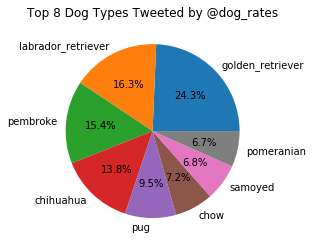

In [147]:
fig = plt.pie(tweet_archive_master.p1.value_counts().head(8), labels = tweet_archive_master.p1.value_counts().head(8).index.tolist(), autopct = '%1.1f%%');
plt.title('Top 8 Dog Types Tweeted by @dog_rates');

In [148]:
#Describe Master Data
tweet_archive_master['rating_fraction']=tweet_archive_master.rating_numerator/tweet_archive_master.rating_denominator

In [149]:
tweet_archive_master.describe()

,rating_numerator,rating_denominator,p1_conf,p2_conf,p3_conf,rating_fraction
count,1987.000000,1987.000000,1987.000000,1.987000e+03,1.987000e+03,1987.000000
mean,12.280825,10.533971,0.593317,1.344725e-01,6.037114e-02,1.169040
std,41.570741,7.333532,0.271959,1.005706e-01,5.091543e-02,4.074226
min,0.000000,2.000000,0.044333,1.011300e-08,1.740170e-10,0.000000
25%,10.000000,10.000000,0.361530,5.409535e-02,1.624950e-02,1.000000
50%,11.000000,10.000000,0.587342,1.175080e-01,4.953060e-02,1.100000
75%,12.000000,10.000000,0.844583,1.950575e-01,9.180755e-02,1.200000
max,1776.000000,170.000000,1.000000,4.880140e-01,2.734190e-01,177.600000


In [150]:
tweet_archive_master.to_csv('tweet_archive_master.csv')

#### Three Insights:
- Golden Retrievers are the most tweeted out dog by dog_rates
- dog_rates uses the class "pupper" the most frequently ~10% of the time
- The average rating given is 11.7/10